In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

# load data

In [4]:
data_dir = 'data'

In [5]:
data_network = pd.read_feather('%s/network.feather'%data_dir)
data_feature = pd.read_feather('%s/feature.feather'%data_dir)

In [6]:
n_node = len(data_feature)
n_edge = len(data_network)

In [7]:
data_network

,row,col
0,1,2
1,2,1
2,2,28
3,3,21
4,3,23
...,...,...
65666,9449,9241
65667,9449,9243
65668,9449,9439
65669,9449,9445


In [8]:
data_feature

,village,hhid,age,educ,native,work,outside,saving,shg,loan
id,,,,,,,,,,
100201,1,1002,38,2,1,1,1,0,0,0
100202,1,1002,27,2,0,0,0,0,0,0
100601,1,1006,29,7,1,1,0,0,0,0
100602,1,1006,24,10,0,1,0,1,1,0
100701,1,1007,58,10,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7516602,75,75166,32,11,0,0,0,1,1,1
7516701,75,75167,45,9,1,1,0,0,0,1
7516702,75,75167,32,9,0,0,0,1,1,1


In [9]:
Adj = sparse.csr_matrix((
    np.full(n_edge, True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [10]:
degree = np.sum(Adj, 0)

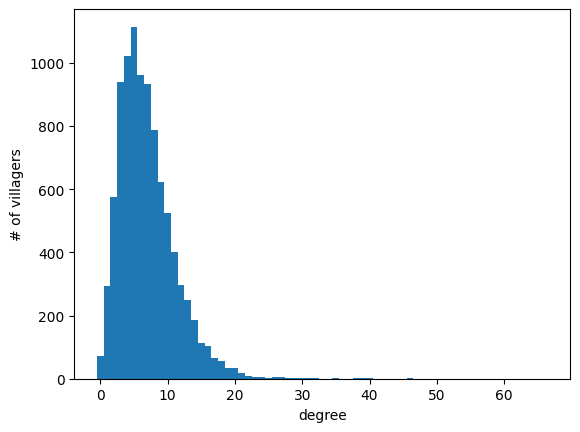

In [128]:
plt.hist(degree, np.arange(np.max(degree)+1)-0.5)
plt.xlabel('degree'), plt.ylabel('# of villagers')
plt.show()

In [12]:
Zs = data_feature.village.values[:,None]

In [13]:
G = KECENI.Graph(Adj, Zs=Zs)

In [14]:
idx_cov = np.array([2, 3, 4, 5, 7])

In [15]:
Ys = data_feature.loan.values.astype(float)[:n_node]
Ts = data_feature.shg.values.astype(float)[:n_node]
Xs = (
    (data_feature.iloc[:n_node,idx_cov].values 
     - np.mean(data_feature.iloc[:n_node,idx_cov].values, 0))
    / np.array([100., 14., 1., 1., 1.])
)

In [16]:
data = KECENI.Data(Ys, Ts, Xs, G)

# counterfactual of interest

In [17]:
i0s = np.array([ 70,   0,   1,  13,   3,   8,  10,   7,   2,  26,  40,  36,   4,
                 28,   5,  20, 123,  99, 318,  38,  87])

In [18]:
T0s_00 = np.full((len(i0s), n_node), 0); T0s_00[np.arange(len(i0s)), i0s] = 0
T0s_01 = np.full((len(i0s), n_node), 1); T0s_01[np.arange(len(i0s)), i0s] = 0
T0s_10 = np.full((len(i0s), n_node), 0); T0s_10[np.arange(len(i0s)), i0s] = 1
T0s_11 = np.full((len(i0s), n_node), 1); T0s_11[np.arange(len(i0s)), i0s] = 1

In [19]:
T0s = np.array([[T0s_00, T0s_01], [T0s_10, T0s_11]])

In [20]:
T0s[...,5,G.N1(i0s[5])]

array([[[0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1]],

       [[1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1]]])

# estimation

In [21]:
from KECENI.RegressionModel import KernelRegressionModel
from KECENI.PropensityModel import KernelIIDPropensityModel
from KECENI.CovariateModel import IIDCovariateModel, CommunityCovariateModel

In [22]:
from delta_fixed import delta_mu, delta_pi, delta

In [23]:
lamda_mu = 3.0
lamda_pi = 4.0
lamdas = 4.0

In [24]:
keceni_model = KECENI.Model(
    KernelRegressionModel(delta_mu, lamda=lamda_mu, ths=1e-7),
    KernelIIDPropensityModel(delta_pi, lamda=lamda_pi, ths=1e-7),
    IIDCovariateModel(),
    delta
)

## - load Fit

In [25]:
num_task = 105

In [26]:
list_fit = list()
for task_id in np.arange(num_task):
    fit_i = KECENI.Fit(
        keceni_model, data,
        **np.load('results/fit_%.3d.npz'%(task_id))
    )
    
    fit_i.xis = np.clip(fit_i.xis, 0, 1)
    
    list_fit.append(fit_i)

## - load KE

In [27]:
list_KE = [
    KECENI.KernelEstimate.KernelEstimate(
        fit_i, i0s, T0s, G,
        Ds = np.load('results/AIPW_spillover_%.3d.npz'%(task_id))['Ds']
    )
    for task_id, fit_i in enumerate(list_fit) 
    if os.path.isfile('results/inf_%.3d.npz'%(task_id))
]

In [28]:
result_KE = KECENI.concat_KEs(list_KE)

In [29]:
result_KE.fit.xis = np.clip(result_KE.fit.xis, 0, 1)

In [36]:
YDRs_0, YDRs_1 = result_KE.est(lamdas)[Ts[degree<21].astype(int),np.arange(2)[:,None],degree[degree<21]]
YDRs_d = YDRs_1 - YDRs_0

## - results

In [37]:
EYDR_0 = np.mean(YDRs_0)
EYDR_1 = np.mean(YDRs_1)
EYDR_d = np.mean(YDRs_d)

In [38]:
EYDR_0, EYDR_1, EYDR_d

(0.3521986420241954, 0.35816672419299345, 0.005968082168798126)

## - plots

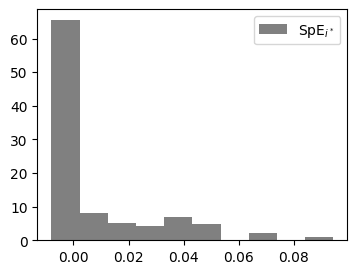

In [39]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_d, density=True, color='grey', label=r'$\mathrm{SpE}_{i^*}$')
plt.legend()

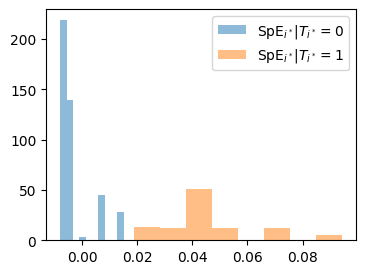

In [40]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_d[Ts[degree<21]==0], alpha=0.5, density=True, label=r'$\mathrm{SpE}_{i^*}|T_{i^*}=0$')
plt.hist(YDRs_d[Ts[degree<21]==1], alpha=0.5, density=True, label=r'$\mathrm{SpE}_{i^*}|T_{i^*}=1$')
plt.legend()

## - SpE$(t)$

In [41]:
YDRs_00, YDRs_01, YDRs_10, YDRs_11 = result_KE.est(lamdas)[:,:,degree[degree<21]].reshape([4,-1])
YDRs_0d = YDRs_01 - YDRs_00
YDRs_1d = YDRs_11 - YDRs_10

In [42]:
EYDR_00 = np.mean(YDRs_00)
EYDR_01 = np.mean(YDRs_01)
EYDR_10 = np.mean(YDRs_10)
EYDR_11 = np.mean(YDRs_11)
EYDR_0d = np.mean(YDRs_0d)
EYDR_1d = np.mean(YDRs_1d)

In [43]:
EYDR_00, EYDR_01, EYDR_0d

(0.3209593530028443, 0.3172890616939579, -0.0036702913088863766)

In [44]:
EYDR_10, EYDR_11, EYDR_1d

(0.48042269731680204, 0.5265869358917892, 0.046164238574986964)

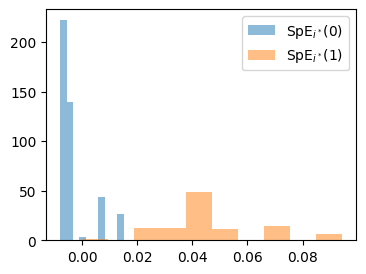

In [45]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_0d, density=True, alpha=0.5, label=r'$\mathrm{SpE}_{i^*}(0)$')
plt.hist(YDRs_1d, density=True, alpha=0.5, label=r'$\mathrm{SpE}_{i^*}(1)$')
plt.legend()

## - by village $k$ and degree $d$

In [46]:
d4 = np.minimum(np.ceil(degree[degree<21]/4), 3).astype(int)

In [47]:
num_group = np.unique(d4).shape[0]

In [48]:
num_group

4

In [49]:
df_boxplot = pd.DataFrame({
    'k': G.Zs[degree<21,0],
    'd': degree[degree<21],
    'd4': d4,
    'YDR_0d': YDRs_0d, 'YDR_1d': YDRs_1d
})

Text(0.5, 1.0, '')

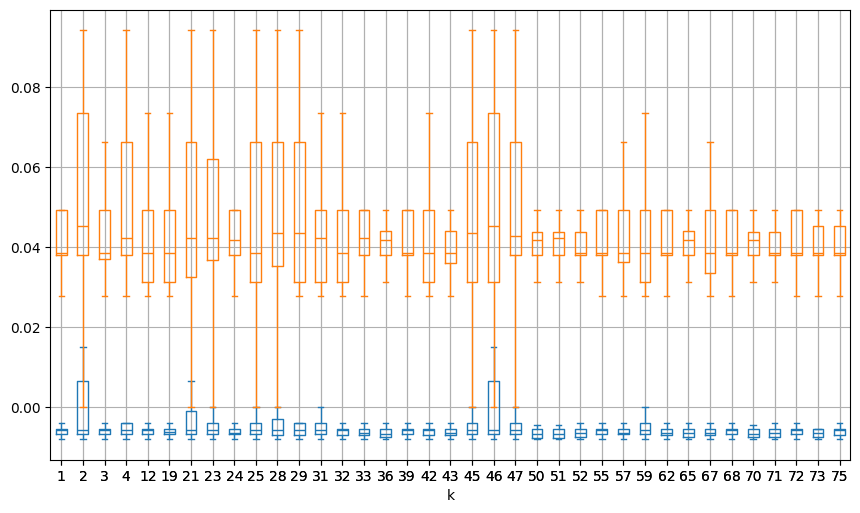

In [50]:
fig = plt.figure(figsize=(10,6)); ax = plt.gca()
df_boxplot.boxplot(column='YDR_0d', by='k', ax=ax, color='C0', showfliers=False)
df_boxplot.boxplot(column='YDR_1d', by='k', ax=ax, color='C1', showfliers=False)

fig.suptitle(''); plt.title('')

Text(0.5, 1.0, '')

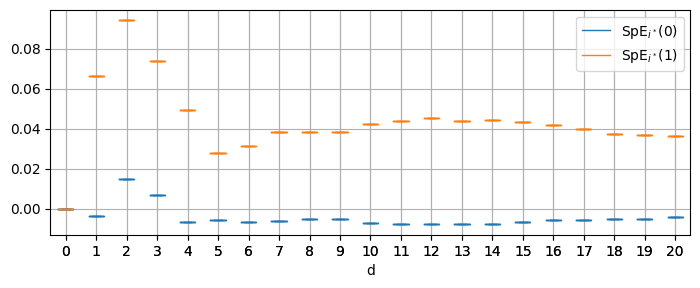

In [51]:
fig = plt.figure(figsize=(8,3)); ax = plt.gca()
bp0 = df_boxplot.boxplot(column='YDR_0d', by='d', ax=ax, color='C0', 
                         showfliers=False, return_type='dict')
bp1 = df_boxplot.boxplot(column='YDR_1d', by='d', ax=ax, color='C1', 
                         showfliers=False, return_type='dict')

ax.legend([bp0['YDR_0d']["boxes"][0], bp1['YDR_1d']["boxes"][0]], 
          [r'$\mathrm{SpE}_{i^*}(0)$', r'$\mathrm{SpE}_{i^*}(1)$'])

fig.suptitle(''); plt.title('')

Text(0.5, 1.0, '')

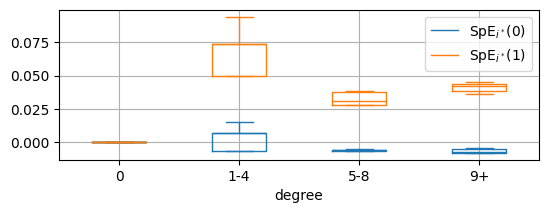

In [52]:
fig = plt.figure(figsize=(6,2)); ax = plt.gca()

bp0 = df_boxplot.boxplot(column='YDR_0d', by='d4', ax=ax, color='C0', 
                         showfliers=False, return_type='dict')
bp1 = df_boxplot.boxplot(column='YDR_1d', by='d4', ax=ax, color='C1', 
                         showfliers=False, return_type='dict')

ax.legend([bp0['YDR_0d']["boxes"][0], bp1['YDR_1d']["boxes"][0]], 
          [r'$\mathrm{SpE}_{i^*}(0)$', r'$\mathrm{SpE}_{i^*}(1)$'])
ax.set_xticks([1, 2, 3, 4], ['0', '1-4', '5-8', '9+'])
# ax.set_xticks([1, 2, 3, 4, 5], ['0', '1-4', '5-8', '9-12', '13+'])
ax.set_xlabel('degree')

fig.suptitle(''); plt.title('')

# inference 

## - phis and Hs

In [53]:
list_Hs_nu, list_Hs_px = list(zip(*[
    dict(np.load('results/inf_%.3d.npz'%(task_id))).values()
    for task_id in range(num_task) 
    if os.path.isfile('results/inf_%.3d.npz'%(task_id))
]))

In [55]:
# list_Hs = [
#     H_i_nu[result_KE.fit.js] + H_i_px[result_KE.fit.js] 
#     for H_i_nu, H_i_px in zip(list_Hs_nu, list_Hs_px)
# ]

In [56]:
list_phis_eif = []; list_wH = []; list_ws = []
for KE_i, H_i_nu, H_i_px in tqdm(zip(list_KE, list_Hs_nu, list_Hs_px), total=num_task):
    ws = KE_i.ws(lamdas)
    est = KE_i.est(lamdas)
    
    phis_eif = (KE_i.fit.xis.reshape((-1,)+(1,)*est.ndim) - est) * ws / np.sum(ws, 0)
    H_i = np.logical_and(KE_i.fit.xis > 0, KE_i.fit.xis < 1)[:,None] * (H_i_nu + H_i_px)
    wH_i = np.sum(H_i.reshape(H_i.shape+(1,)*est.ndim) * ws[:,None], 0) / np.sum(ws, 0)
    
    list_phis_eif.append(phis_eif)
    list_wH.append(wH_i)
    list_ws.append(np.sum(ws, 0))

100%|█████████████████████████████████████████████████████████████| 105/105 [00:52<00:00,  2.02it/s]


In [57]:
phis_sdw_dr = KECENI.concat_phis(list_ws, list_phis_eif, list_wH) # [ind_js]

## - distance in $\mathcal{G}$

In [60]:
from KECENI.Inference import ste_hac_sdw, bbb_sdw

In [61]:
G.get_dist()

array([[ 0.,  1.,  5., ..., inf, inf, inf],
       [ 1.,  0.,  4., ..., inf, inf, inf],
       [ 5.,  4.,  0., ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ...,  0.,  2.,  1.],
       [inf, inf, inf, ...,  2.,  0.,  2.],
       [inf, inf, inf, ...,  1.,  2.,  0.]])

In [62]:
G_sub = G.sub(result_KE.fit.js)

In [63]:
G_sub.dist = G.dist[np.ix_(result_KE.fit.js, result_KE.fit.js)]

In [64]:
G_sub.dist

array([[ 0.,  1.,  5., ..., inf, inf, inf],
       [ 1.,  0.,  4., ..., inf, inf, inf],
       [ 5.,  4.,  0., ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ...,  0.,  2.,  1.],
       [inf, inf, inf, ...,  2.,  0.,  2.],
       [inf, inf, inf, ...,  1.,  2.,  0.]])

## - results on SpE

In [67]:
phis = phis_sdw_dr

In [68]:
counts_0 = np.array([np.sum(degree[Ts==0] == k) for k in np.arange(21)])
counts_1 = np.array([np.sum(degree[Ts==1] == k) for k in np.arange(21)])
counts = counts_0 + counts_1

In [69]:
phis_0 = (
    np.sum(phis[:,0,0] * counts_0 + phis[:,1,0] * counts_1, -1) 
    / np.sum(counts)
)
phis_1 = (
    np.sum(phis[:,0,1] * counts_0 + phis[:,1,1] * counts_1, -1) 
    / np.sum(counts)
)

In [70]:
std_0 = ste_hac_sdw(phis_0, G_sub, bw=5)
std_1 = ste_hac_sdw(phis_1, G_sub, bw=5)

### * confidence intervals

In [71]:
(np.mean(YDRs_0) - 2 * std_0,
 np.mean(YDRs_0) + 2 * std_0)

(0.3371512954230541, 0.36724598862533664)

In [72]:
(np.mean(YDRs_1) - 2 * std_1,
 np.mean(YDRs_1) + 2 * std_1)

(0.34108643652655435, 0.37524701185943254)

In [73]:
bbb_0 = bbb_sdw(phis_0, G_sub, hops = 5, n_bst=100, tqdm=tqdm).flatten()
bbb_1 = bbb_sdw(phis_1, G_sub, hops = 5, n_bst=100, tqdm=tqdm).flatten()

bst: 100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 709.70it/s]


(array([ 3.41454187,  1.13818062, 14.7963481 , 19.34907059, 23.90179308,
        31.86905744, 10.24362561,  5.69090311,  2.27636125,  1.13818062]),
 array([0.31287771, 0.32166366, 0.33044962, 0.33923557, 0.34802152,
        0.35680747, 0.36559342, 0.37437937, 0.38316533, 0.39195128,
        0.40073723]),
 <BarContainer object of 10 artists>)

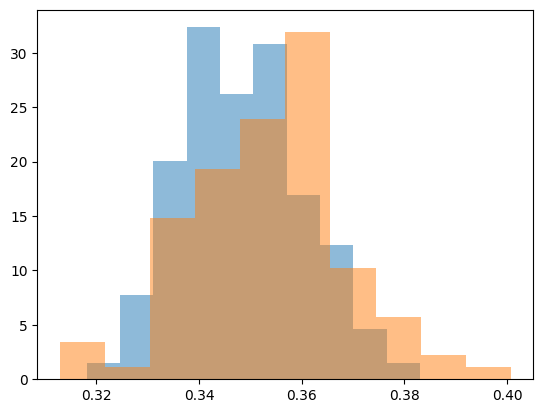

In [74]:
plt.hist(bbb_0 + np.mean(YDRs_0), alpha=0.5, density=True)
plt.hist(bbb_1 + np.mean(YDRs_1), alpha=0.5, density=True)

In [75]:
std_d = ste_hac_sdw(phis_1 - phis_0, G_sub, bw=5)

In [76]:
bbb_d = bbb_sdw(phis_1 - phis_0, G_sub, 5, n_bst=100, tqdm=tqdm).flatten()

bst: 100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 732.74it/s]


(array([ 1.,  3.,  4., 12., 19., 22., 21., 11.,  6.,  1.]),
 array([-0.00978626, -0.00738777, -0.00498928, -0.00259078, -0.00019229,
         0.0022062 ,  0.00460469,  0.00700319,  0.00940168,  0.01180017,
         0.01419867]),
 <BarContainer object of 10 artists>)

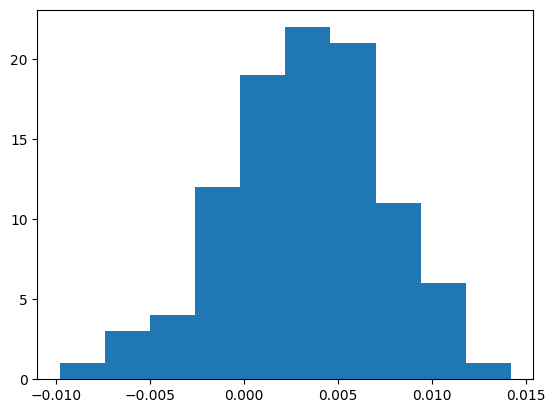

In [77]:
plt.hist(bbb_d + np.mean(YDRs_1) - np.mean(YDRs_0))

In [78]:
2 * (1 - np.mean(bbb_d - np.mean(bbb_d) + np.mean(YDRs_1) - np.mean(YDRs_0) > 0))

0.15999999999999992

In [79]:
np.quantile(bbb_d - np.mean(bbb_d) + np.mean(YDRs_1) - np.mean(YDRs_0), (0.025, 0.975))

array([-0.00283558,  0.01350753])

In [80]:
(np.mean(YDRs_1) - np.mean(YDRs_0) - 2 * np.sqrt(np.mean(bbb_d**2)),
 np.mean(YDRs_1) - np.mean(YDRs_0) + 2 * np.sqrt(np.mean(bbb_d**2)))

(-0.004224990072654384, 0.01616115441025053)

In [129]:
(np.mean(YDRs_1) - np.mean(YDRs_0) - 2 * std_d, np.mean(YDRs_1) - np.mean(YDRs_0),
 np.mean(YDRs_1) - np.mean(YDRs_0) + 2 * std_d)

(-0.002118446402884465, 0.005968082168798072, 0.01405461074048061)

## - results on SpE$(t)$

In [82]:
phis_0d = np.sum((phis[:,0,1,:] - phis[:,0,0,:]) * counts, -1) / np.sum(counts)
phis_1d = np.sum((phis[:,1,1,:] - phis[:,1,0,:]) * counts, -1) / np.sum(counts)

In [83]:
std_0d = ste_hac_sdw(phis_0d, G_sub, bw=5)
std_1d = ste_hac_sdw(phis_1d, G_sub, bw=5)

### * confidence intervals

In [87]:
(np.mean(YDRs_0d) - 2 * std_0d, np.mean(YDRs_0d),
 np.mean(YDRs_0d) + 2 * std_0d)

(-0.012309858297959924, -0.0036702913088863766, 0.004969275680187172)

In [89]:
(np.mean(YDRs_1d) - 2 * std_1d, np.mean(YDRs_1d),
 np.mean(YDRs_1d) + 2 * std_1d)

(0.02958933068434316, 0.046164238574986964, 0.06273914646563077)

### * by degree $d$

In [94]:
phis_0d_by_d = phis[:,0,1] - phis[:,0,0]
phis_1d_by_d = phis[:,1,1] - phis[:,1,0]

In [95]:
std_0d_by_d = ste_hac_sdw(phis_0d_by_d, G_sub, bw=5)
std_1d_by_d = ste_hac_sdw(phis_1d_by_d, G_sub, bw=5)

#### confidence intervals

In [99]:
df_boxplot.groupby('d').mean()['YDR_0d'].values[:21, None] + (-2, 2) * std_0d_by_d[:,None]

array([[ 0.        ,  0.        ],
       [-0.02550172,  0.01778461],
       [-0.0022803 ,  0.03228015],
       [-0.00751647,  0.02081457],
       [-0.01932444,  0.00582879],
       [-0.0166706 ,  0.00552079],
       [-0.01683732,  0.00323693],
       [-0.01548925,  0.00277761],
       [-0.01386853,  0.0031298 ],
       [-0.01367528,  0.00290913],
       [-0.0159218 ,  0.00123466],
       [-0.01640522,  0.00042375],
       [-0.01642478,  0.00074911],
       [-0.0166024 ,  0.00145436],
       [-0.01820422,  0.00266828],
       [-0.0173719 ,  0.0038644 ],
       [-0.01692685,  0.00544153],
       [-0.01795678,  0.00690101],
       [-0.01758276,  0.00669296],
       [-0.017099  ,  0.00681482],
       [-0.01636982,  0.00738983]])

In [100]:
df_boxplot.groupby('d').mean()['YDR_1d'].values[:21, None] + (-2, 2) * std_1d_by_d[:,None]

array([[0.        , 0.        ],
       [0.03653275, 0.09641859],
       [0.04542194, 0.14323584],
       [0.04869841, 0.09875601],
       [0.02289109, 0.07583624],
       [0.00469999, 0.05112419],
       [0.01153783, 0.05091786],
       [0.01950062, 0.05753327],
       [0.01861813, 0.05747039],
       [0.01738454, 0.05966921],
       [0.02230561, 0.06215802],
       [0.02436876, 0.06349784],
       [0.02507255, 0.06541796],
       [0.02163839, 0.0654742 ],
       [0.01822509, 0.06996911],
       [0.01167658, 0.07514013],
       [0.0113217 , 0.07238092],
       [0.00934921, 0.0700063 ],
       [0.00631009, 0.06791803],
       [0.0059504 , 0.06728144],
       [0.00502815, 0.0671554 ]])

### * by degree groups

In [104]:
counts_by_d4 = np.zeros((21, num_group))

In [105]:
unique_vectors, counts = np.unique(np.stack([degree[degree < 21], d4], -1), axis=0, return_counts=True)

In [106]:
counts_by_d4[*unique_vectors.T] = counts

In [107]:
counts_by_d4

array([[  72.,    0.,    0.,    0.],
       [   0.,  295.,    0.,    0.],
       [   0.,  576.,    0.,    0.],
       [   0.,  940.,    0.,    0.],
       [   0., 1021.,    0.,    0.],
       [   0.,    0., 1114.,    0.],
       [   0.,    0.,  961.,    0.],
       [   0.,    0.,  932.,    0.],
       [   0.,    0.,  786.,    0.],
       [   0.,    0.,    0.,  624.],
       [   0.,    0.,    0.,  523.],
       [   0.,    0.,    0.,  401.],
       [   0.,    0.,    0.,  297.],
       [   0.,    0.,    0.,  248.],
       [   0.,    0.,    0.,  186.],
       [   0.,    0.,    0.,  112.],
       [   0.,    0.,    0.,  105.],
       [   0.,    0.,    0.,   64.],
       [   0.,    0.,    0.,   57.],
       [   0.,    0.,    0.,   35.],
       [   0.,    0.,    0.,   34.]])

In [108]:
np.sum(counts_by_d4, 0)

array([  72., 2832., 3793., 2686.])

In [109]:
phis_by_d4 = phis @ counts_by_d4 / np.sum(counts_by_d4, 0)

In [111]:
phis_0d_by_d4 = phis_by_d4[:,0,1] - phis_by_d4[:,0,0]
phis_1d_by_d4 = phis_by_d4[:,1,1] - phis_by_d4[:,1,0]

In [112]:
std_0d_by_d4 = ste_hac_sdw(phis_0d_by_d4, G_sub, bw=5)
std_1d_by_d4 = ste_hac_sdw(phis_1d_by_d4, G_sub, bw=5)

#### confidence intervals

In [114]:
(
    df_boxplot.groupby('d4').mean()['YDR_0d'].values[:,None] 
    + (-2, 2) * std_0d_by_d4[:,None]
)

array([[ 0.        ,  0.        ],
       [-0.01011035,  0.01495657],
       [-0.01542616,  0.00335689],
       [-0.0151961 ,  0.00148708]])

In [115]:
(
    df_boxplot.groupby('d4').mean()['YDR_1d'].values[:,None] 
    + (-2, 2) * std_1d_by_d4[:,None]
)

array([[0.        , 0.        ],
       [0.04518381, 0.091573  ],
       [0.01387704, 0.05303812],
       [0.02157858, 0.06226863]])

#### p-values

In [122]:
std_1d_by_d4_4x4 = ste_hac_sdw(
    phis_1d_by_d4[...,:,None] - phis_1d_by_d4[...,None,:],
    G_sub, bw=5
)

In [123]:
import scipy as sp

In [124]:
pvals = 1 - sp.stats.norm().cdf(
    np.abs(
        df_boxplot.groupby('d4').mean()['YDR_1d'].values[:,None]
        - df_boxplot.groupby('d4').mean()['YDR_1d'].values[None,:]
    ) / std_1d_by_d4_4x4
)

/tmp/ipykernel_297273/4203635088.py:2: RuntimeWarning: invalid value encountered in divide
  np.abs(


In [125]:
pvals

array([[           nan, 1.86137683e-09, 3.16075110e-04, 1.88400587e-05],
       [1.86137683e-09,            nan, 1.43406430e-03, 2.57761142e-02],
       [3.16075110e-04, 1.43406430e-03,            nan, 1.33901525e-01],
       [1.88400587e-05, 2.57761142e-02, 1.33901525e-01,            nan]])